# Taller Regresión lineal, Ridge y Lasso

cEn este taller analizaremos métodos de regresión lineal para el conjunto de datos [Hitters](https://www.kaggle.com/datasets/floser/hitters). Cada registro corresponde a un jugador de baseball. Las variables son registros como cantidad de *home runs* o número de años en las ligas mayores. La variable objetivo es el salario de dicho jugador.
Usaremos regresión de Ridge y Lasso y las compararemos.

- Subir el documento en dos formatos : 1. En formato .ipynb  2. En formato .html.
- Enviar a más tardar el martes 10 de octubre.



In [1]:
#importar paquetes
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import random

from sklearn.preprocessing import StandardScaler

In [2]:
#Evitar la impresión de warnings
import warnings
warnings.filterwarnings("ignore")

En primer lugar, leemos el conjunto de datos e imprimimos la información sobre sus columnas.

In [3]:
df = pd.read_csv('Hitters.csv').dropna()
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

In [4]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


1. Codificar las variables categóricas como variables Dummy. Separar la variable objetivo con el nombre 'y'. El resto del dataset llamarlo 'X'.

In [5]:
# Cambiamos las variables categoricas (Leangue, Division y NewLeague) como variables Dummy

df = pd.get_dummies(df,columns=['League'])
df = pd.get_dummies(df,columns=['Division'])
df = pd.get_dummies(df,columns=['NewLeague'])
df.head()


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0


In [6]:
# Separamos la variable objetivo con el nombre 'y'. El resto del dataset llamarlo 'X'.
y = df['Salary']
X = df.drop(columns=['Salary'])

Vamos a generar valores de Lambda equidistantes para experimentar sobre un intervalo. Estos valores se encuentran entre 10^(-2) y 10^10. Experimentaremos con 100 valores distintos de lambda. Para esto usamos *linspace* de Numpy:

In [7]:
# Creamos una lista con posibles valores para el parámetro Lambda para los algoritmos Ridge y Lasso
lambdas = 10**np.linspace(10,-2,100)
lambdas

array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.84803587e+07, 2.15443469e+07, 1.62975083e+07,
       1.23284674e+07, 9.32603347e+06, 7.05480231e+06, 5.33669923e+06,
       4.03701726e+06, 3.05385551e+06, 2.31012970e+06, 1.74752840e+06,
       1.32194115e+06, 1.00000000e+06, 7.56463328e+05, 5.72236766e+05,
       4.32876128e+05, 3.27454916e+05, 2.47707636e+05, 1.87381742e+05,
       1.41747416e+05, 1.07226722e+05, 8.11130831e+04, 6.13590727e+04,
       4.64158883e+04, 3.51119173e+04, 2.65608778e+04, 2.00923300e+04,
       1.51991108e+04, 1.14975700e+04, 8.69749003e+03, 6.57933225e+03,
       4.97702356e+03, 3.76493581e+03, 2.84803587e+03, 2.15443469e+03,
      

Vamos a usar el algoritmo de Ridge de SKlearn para hacer regresión con los diferentes valores del parámetro Lambda, de manera que podamos realizar algunas observaciones y comparaciones.

In [8]:
# Aplicamos el algoritmo Ridge de SKlearn para los diferentes valores de Lambda definidos
# en la celda anterior. Se guardan los vectores obtenidos de parámetros en la lista coefs.

#scaler = StandardScaler()
#X = scaler.fit_transform(X)  # Escala tus datos de entrada X

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

X = (X - mean) / std

ridge = Ridge(X)
coefs = []

for a in lambdas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
#Imprimir las dimensiones de la matriz coef.
np.shape(coefs)

(100, 22)

Usamos los arreglos *lambdas* y *coefs* para comparar los resultados de la regresión Ridge para diferentes valores del parámetro Lambda.

Text(0, 0.5, 'weights')

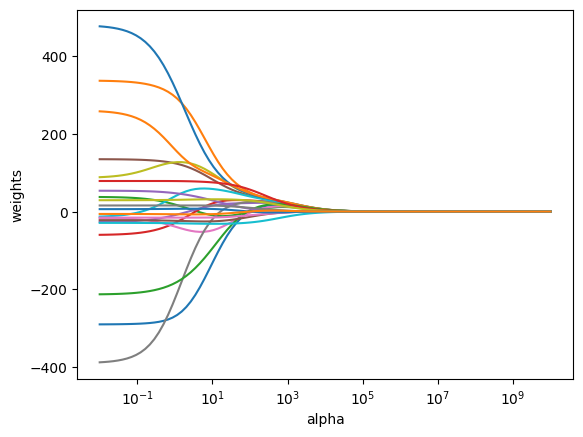

In [9]:
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

2. Interprete la gráfica, escriba las conclusiones que pueda obtener de la misma.

Podemos ver como los coeficientes del modelo de regresión de Ridge cambian a medida que variamos alpha. Además, podemos ver que a medida que alpha aumenta empieza a tender a cero, esto se debe a Ridge penaliza los valores extremos de los coeficientes, por lo que cuanto mayor sea alpha, más fuerte será la penalización.  

3. Hallar el coeficiente de las variables Hits Runs y Walks, arrojado por el algoritmo Ridge, para 3 lambdas distintos.
Ejemplo: "Para lambda=3.06795364e+00, el coeficiente de Hits es (valor), el coeficiente de Runs es (valor) y el coeficiente de Walks es (valor)."

In [10]:
print(f'El coeficiente de Hits para lambda = {lambdas[2]}, es:{coefs[2][1]}')

print(f'El coeficiente de Runs para lambda = {lambdas[4]}, es:{coefs[4][1]}')

print(f'El coeficiente de Walks para lambda = {lambdas[6]}, es:{coefs[6][1]}')

El coeficiente de Hits para lambda = 5722367659.35022, es:9.077914161448398e-06
El coeficiente de Runs para lambda = 3274549162.877732, es:1.5863909336268726e-05
El coeficiente de Walks para lambda = 1873817422.8603868, es:2.7722621492123207e-05


4. Separar el conjunto de datos en conjunto de Entrenamiento y Testeo (Usar randomstate= 0). Aplicar el algoritmo de regresión lineal a este conjunto de datos. Imprimir el coeficiente de determinación R^2.


In [14]:
#separamos el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.2)

In [15]:
# Aplicamos el algoritmo
regr = LinearRegression()
regr.fit(X_train, y_train)

#imprimimmos R^2
print("score = ", regr.score(X_test, y_test))

score =  0.5611397314906121


5. Cuáles son los valores de los parámetros en el modelo lineal obtenido? ¿Cuál valor corresponde con cuál variable en el Dataset?

In [16]:
print('slope:', regr.coef_)
print('intercept:', regr.intercept_)

slope: [-269.66873016  316.23299124   98.59022678  -45.54845094  -75.1973347
  159.55817833   28.0289812  -340.37980202  198.37860122  -53.56211203
  335.94299118  224.34107838 -227.51847185   53.96732383   66.60677746
  -38.31327391   -8.03655783    8.03655783   28.63329435  -28.63329435
   -1.05649609    1.05649609]
intercept: 530.684214194494


## Regresión Ridge
Ahora apliquemos Regresión de Ridge para algunos valores de lambda. En primer lugar usemos Lambda=4.

In [21]:
#Modelo de regresión de Ridge para Lambda=4
# Note el uso del parámetro normalize=True

#Normaizamos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

ridge = Ridge(alpha = 4)
ridge.fit(X_train, y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print(pd.Series(ridge.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print(mean_squared_error(y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print(ridge.score(X_test, y_test))         #Imprimir el coeficiente de determinación R^2

AtBat         -172.811551
Hits           192.221437
HmRun           50.334365
Runs            14.410034
RBI            -21.771610
Walks          113.485521
Years           -6.643784
CAtBat         -35.940855
CHits          127.972578
CHmRun          -3.948386
CRuns          133.427502
CRBI            94.917992
CWalks        -145.060386
PutOuts         54.368041
Assists         50.088006
Errors         -41.046695
League_A        -8.721136
League_N         8.721136
Division_E      30.080155
Division_W     -30.080155
NewLeague_A     -0.185986
NewLeague_N      0.185986
dtype: float64
135343.1393157194
0.5397694561671942


6. ¿Cuál debería ser el coeficiente de determinación R^2 al asignar Lambda=0? Justifique y compruebe en la siguiente celda.

Como Lambda = 0, el coeficiente de determminación R^2 sería el mismo que en la regresión normal ya que estamos volviendo a la formula de la regresión lineal y descartamos la suma extra que se le agrega a la regresión de Ridge.

In [26]:
# Verifique su respuesta anterior.
# Usar el parámetro normalize=True

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

ridge = Ridge(alpha = 0)
ridge.fit(X_train, y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print(pd.Series(ridge.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print(mean_squared_error(y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print(ridge.score(X_test, y_test))         #Imprimir el coeficiente de determinación R^2

AtBat         -2.756033e+02
Hits           3.250360e+02
HmRun          9.881811e+01
Runs          -5.243339e+01
RBI           -7.195313e+01
Walks          1.559523e+02
Years          1.926290e+01
CAtBat        -3.222844e+02
CHits          2.002117e+02
CHmRun        -4.224594e+01
CRuns          3.113061e+02
CRBI           2.141242e+02
CWalks        -2.291797e+02
PutOuts        6.153734e+01
Assists        7.233049e+01
Errors        -3.821743e+01
League_A      -3.164168e+15
League_N      -3.164168e+15
Division_E    -2.485686e+16
Division_W    -2.485686e+16
NewLeague_A   -2.601558e+16
NewLeague_N   -2.601558e+16
dtype: float64
128136.83832167895
0.5642742802925862


A continuación aplicamos validación cruzada para el algoritmo de Ridge.

7. Investigue los parámetros de RidgeCV y explíquelos. Aplique el algoritmo con diferentes posibilidades para el parámetro 'cv'. Guarde los diferentes valores de alpha obtenidos.

1. alphas: Es una lista o arreglo de valores de alpha que se probarán durante la búsqueda. Por defecto, alphas=None, lo que significa que se probarán varios valores de alpha en una escala predeterminada. Puedes proporcionar una lista personalizada de valores de alpha si lo deseas.

2. store_cv_values: Un valor booleano (True o False) que controla si se deben almacenar los valores de error cuadrático medio (MSE) de la validación cruzada para cada valor de alpha. Esto puede ser útil para analizar el rendimiento del modelo en diferentes valores de alpha.

3. cv: El número de divisiones (folds) en la validación cruzada. Por defecto, cv=None, lo que significa que se utiliza validación cruzada k-fold con k = 5. Puedes especificar un valor entero para controlar el número de divisiones.

4. normalize: Un valor booleano (True o False) que controla si las características deben normalizarse antes de ajustar el modelo. Si se establece en True, las características se normalizarán antes del ajuste.

5. scoring: La métrica utilizada para evaluar el rendimiento del modelo durante la validación cruzada. Por defecto, se utiliza la métrica R^2 (coeficiente de determinación), pero puedes especificar cualquier métrica de regresión admitida por scikit-learn.

In [28]:
# con RidgeCV de SKLearn hacer cross validation con la lista de Lambdas y normalize True
# Imprimir el alpha optimo. Note que usamos el parametro normalize=True
# Valores de alpha que se probarán

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

ridgecv = RidgeCV(alphas = lambdas)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_


3.5111917342151275

8. Con los diferentes valores de alpha obtenidos, aplique el algoritmo de Ridge. Calcule el error cuadrático MSE, el error absoluto medio MAE y el coeficiente de determinación. Usar el parámetro normalize = True.

In [29]:
#TO_DO 10 Con el alpha optimo hallado arriba, calcular los coeficientes(parámetros),
# el error cuadrático MSE y el coeficiente de determinación R^2 en el conjunto de Testeo.
# Usar el parámetro normalize=True
# Valores de alpha obtenidos anteriormente

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(X_train, y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print(pd.Series(ridge.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print(mean_squared_error(y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print(ridge.score(X_test, y_test))

AtBat         -182.154423
Hits           201.659659
HmRun           53.074937
Runs            11.550817
RBI            -24.495546
Walks          116.771012
Years           -6.068435
CAtBat         -44.686969
CHits          131.424927
CHmRun          -4.818644
CRuns          141.136272
CRBI            98.411076
CWalks        -151.329171
PutOuts         54.646675
Assists         51.346100
Errors         -41.048848
League_A        -8.674010
League_N         8.674010
Division_E      30.053513
Division_W     -30.053513
NewLeague_A     -0.200706
NewLeague_N      0.200706
dtype: float64
134980.3405091314
0.5410031433189928


## Regresión Lasso
Ahora aplicaremos regresión Lasso a éste conjunto de datos.
9. Encontrar el valor óptimo de alpha con el algoritmo LassoCV de SKlearn.


In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

lassocv = LassoCV(alphas = lambdas)
lassocv.fit(X_train, y_train)
lassocv.alpha_

18.738174228603867

10. Aplicar el algoritmo de LASSO con el valor óptimo de alpha encontrado anteriormente. Utilizar normalización. Imprimir los coeficientes y el coeficiente de determinación.

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(X_train, y_train)
pred = lasso.predict(X_test)
print(mean_squared_error(y_test, pred))

148989.67440460372


In [34]:
pd.Series(lasso.coef_, index=X.columns)

AtBat          0.000000e+00
Hits           9.182168e+01
HmRun          7.107910e+00
Runs           0.000000e+00
RBI            0.000000e+00
Walks          5.590092e+01
Years          0.000000e+00
CAtBat         0.000000e+00
CHits          8.633647e+01
CHmRun         0.000000e+00
CRuns          3.151014e+01
CRBI           5.344469e+01
CWalks         0.000000e+00
PutOuts        3.273924e+01
Assists       -0.000000e+00
Errors        -3.855281e+00
League_A      -0.000000e+00
League_N       0.000000e+00
Division_E     4.378011e+01
Division_W    -1.082732e-14
NewLeague_A   -0.000000e+00
NewLeague_N    0.000000e+00
dtype: float64

In [35]:
#Imprimimos el score (R^2)
print(lassocv.score(X_test, y_test))

0.49336479689045143


11. Escriba sus conclusiones acerca de los diferentes modelos obtenidos y sus métricas.

En resumen, al analizar ambas regresiones, notamos que nuestro rendimiento en el conjunto de entrenamiento apenas mejora en comparación con la regresión lineal original. Esto podría deberse a la calidad de los datos que estamos utilizando y la posible presencia de variables que introducen ruido en el modelo. Además, al ajustar el valor óptimo de alpha, observamos que los modelos tienden a empeorar, lo que también podría ser atribuible a la base de datos en sí.

Específicamente, notamos que la regresión de Lasso elimina muchos coeficientes de las variables, lo que sugiere una correlación deficiente entre las variables o la presencia de una relación lineal débil entre ellas, lo que afecta negativamente al modelo. Sin embargo, también consideramos que quizás los modelos utilizados no son los más adecuados para este conjunto de datos en particular, y esperamos explorar diferentes enfoques para obtener resultados más satisfactorios.